In [24]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from tensorflow import keras

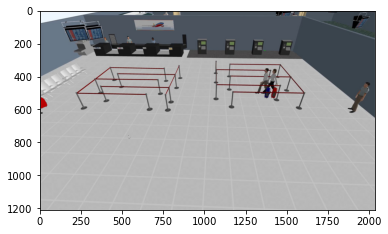

In [4]:
img = plt.imread('train/frames/frame0.jpg')   # reading image using its name
plt.imshow(img)

In [5]:
data = pd.read_csv('train/frames.csv')     # reading the csv file
data.head()      # printing first five rows of the file

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,1
3,frame3.jpg,1
4,frame4.jpg,1


In [8]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('train/frames/' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

<ipython-input-8-a3a87d291a0a>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(X)    # converting list to array


In [9]:
y = data.Class
dummy_y = np_utils.to_categorical(y) 

In [10]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [11]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
X = preprocess_input(X, mode='caffe')   

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42) 

In [13]:
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Sequential

In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

In [15]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

((624, 7, 7, 2048), (268, 7, 7, 2048))

In [17]:
X_train = X_train.reshape(X_train.shape[0], 7*7*2048)      # converting to 1-D
X_valid = X_valid.reshape(X_valid.shape[0], 7*7*2048)

In [18]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [19]:
# i. Building the model
model = Sequential()
model.add(InputLayer((7*7*2048,)))    # input layer
model.add(Dense(units=2048, activation='sigmoid'))   # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(units=1024, activation='sigmoid'))    # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(units=512, activation='sigmoid'))    # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(5, activation='softmax'))            # output layer

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2

In [21]:
# ii. Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# iii. Training the model
model.fit(train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
20/20 [==============================] - 11s 514ms/step - loss: 1.6800 - accuracy: 0.3205 - val_loss: 0.7106 - val_accuracy: 0.7612
Epoch 2/20
20/20 [==============================] - 10s 499ms/step - loss: 0.7075 - accuracy: 0.6981 - val_loss: 0.2104 - val_accuracy: 0.9552
Epoch 3/20
20/20 [==============================] - 10s 498ms/step - loss: 0.1981 - accuracy: 0.9314 - val_loss: 0.1153 - val_accuracy: 0.9739
Epoch 4/20
20/20 [==============================] - 10s 495ms/step - loss: 0.0558 - accuracy: 0.9961 - val_loss: 0.0536 - val_accuracy: 0.9813
Epoch 5/20
20/20 [==============================] - 10s 499ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 0.9776
Epoch 6/20
20/20 [==============================] - 10s 498ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0461 - val_accuracy: 0.9813
Epoch 7/20
20/20 [==============================] - 10s 497ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0385 - val_accuracy: 0.9813

In [23]:
model.save('train/model')

INFO:tensorflow:Assets written to: train/model\assets


In [26]:
model = keras.models.load_model('train/model')